# Bisimulation Metric


In [66]:
import numpy as np
from collections import defaultdict

ACTION_SPACE = ['up', 'down', 'left', 'right']
POLICYACTION2ACTION = { 'u' : 'up',
                 'd' : 'down', 
                 'l' : 'left', 
                 'r' : 'right', 
                 'G' : 'right'} # Assume right from the goal

def get_next_state(r, c, action, grid_shape):
    rows, cols = grid_shape

    if action == 'up':
        return max(r - 1, 0), c
    elif action == 'down':
        return min(r + 1, rows - 1), c
    elif action == 'left':
        return r, max(c - 1, 0)
    elif action == 'right':
        return r, min(c + 1, cols - 1)
    
def reward_function(state, action, grid):
    r, c = state

    # NOTE: This environment is deterministic for that reason
    # and action only lead to one next possible state
    next_state = get_next_state(r, c, action, grid.shape)

    # Define the reward if you are in the terminal state
    if grid[state] == 'G':
        return 0
    
    # Define all the other rewards
    if grid[next_state] == 'G':
        return 1
    elif grid[next_state] == 'x' or state == next_state:
        return -1
    else:
        return 0
    
def transition_function(state, action, grid):
    r, c = state

    # NOTE: This environment is deterministic for that reason
    # and action only lead to one next possible state
    next_state = get_next_state(r, c, action, grid.shape)

    # Define the transition if you are in the terminal state
    if grid[state] == 'G':
        return {next_state: 0.} # Terminal state not other possible transition
    
    # Define all the other transitions
    if grid[next_state] == 'x' or state == next_state:
        return {state: 1.} # Transition to the same state
    else:
        return {next_state: 1.} # Transition to the next state   
    
def read_grid_world(file_path):
    with open(file_path, 'r') as file:
        grid = [line.split() for line in file]
    return np.array(grid)

def calculate_rewards_and_transitions(grid):
    states = []
    rewards = defaultdict(dict)
    transitions = defaultdict(dict)
    for row in range(grid.shape[0]):
        for col in range(grid.shape[1]):
            state = (row, col)

            if grid[row, col] != 'x':
                states.append(state)
                
                for action in ACTION_SPACE:
                    rewards[state][action] = reward_function(state, action, grid)
                    transitions[state][action] = transition_function(state, action, grid)

    return states, rewards, transitions

In [67]:
def compute_bisimulation_metric(grid, states, rewards, gamma = 0.9, epsilon=1e-5, policy = None):
    """
    Compute the on-policy bisimulation metric for a given MDP and policy.

    Parameters:
    - grid: Grid world environment.
    - states: List of states each state is a tuple (x,y).
    - rewards: Function R(s, a).
    - gamma: Discount factor.
    - epsilon: Convergence threshold.
    - policy: Function π(a | s). It is a matrix of size similar to the grid

    Returns:
    - d: On-policy bisimulation metric.
    """
    n_states = len(states)
    d = np.zeros((n_states, n_states))

    def distance_update(d):
        new_d = np.zeros_like(d)
        for i, s in enumerate(states):
            for j, t in enumerate(states):
                if i != j:

                    # Compute on-policy bisimulation metric
                    if policy:
                        action_s = POLICYACTION2ACTION[policy[s]]
                        action_t = POLICYACTION2ACTION[policy[t]]

                        next_s = get_next_state(s[0], s[1], action_s, grid.shape)
                        next_t = get_next_state(t[0], t[1], action_t, grid.shape)

                        # Get the index of the next states
                        next_s_i = states.index(next_s)
                        next_t_j = states.index(next_t)

                        reward_diff = abs(rewards[s][action_s] - rewards[t][action_t])
                        transition_diff = gamma * d[next_s_i][next_t_j]

                        new_d[i][j] = reward_diff + transition_diff

                    # Compute standard bisimulation metric
                    else:
                        for action in ACTION_SPACE:
                            next_s = get_next_state(s[0], s[1], action, grid.shape)
                            next_t = get_next_state(t[0], t[1], action, grid.shape)

                            if next_s in states and next_t in states:
                                # Get the index of the next states
                                next_s_i = states.index(next_s)
                                next_t_j = states.index(next_t)

                                reward_diff = abs(rewards[s][action] - rewards[t][action])
                                transition_diff = gamma * d[next_s_i][next_t_j]

                                act_distance = reward_diff + transition_diff

                                # Get the indext of current states
                                s_i = states.index(s)
                                t_j = states.index(t)

                                if act_distance > new_d[s_i,t_j]:
                                    new_d[s_i, t_j] = act_distance
        return new_d

    while True:
        new_d = distance_update(d)
        if np.max(np.abs(new_d - d)) < epsilon:
            break
        d = new_d

    return d

In [68]:
file_path = 'custom_envs/grid_world.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)
states

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' 'x' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]


[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2)]

In [70]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards)
d.shape

(12, 12)

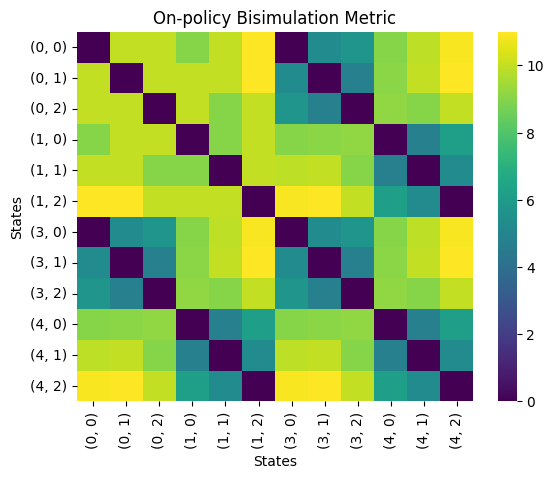

In [71]:
plot_distance_matrix(d, states)

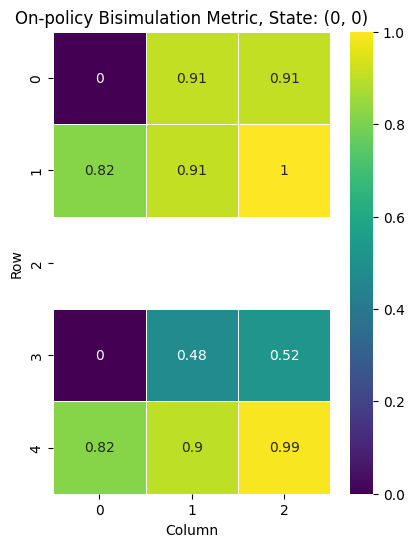

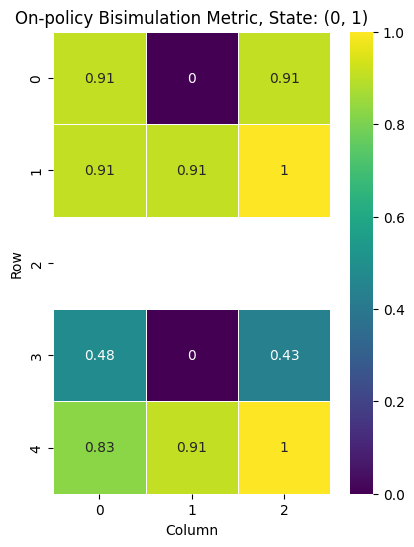

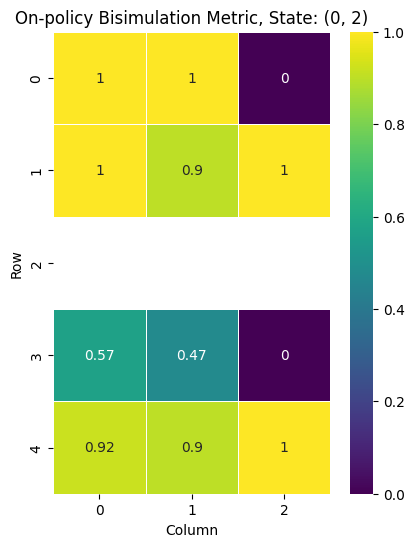

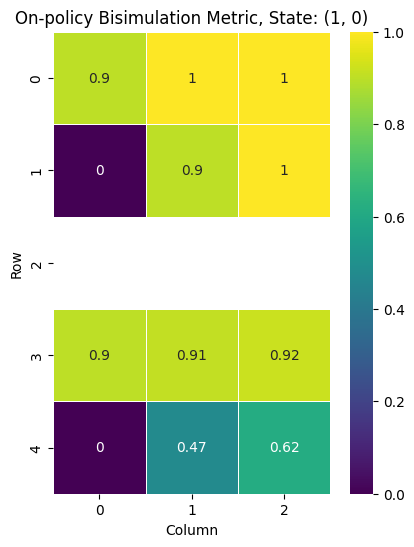

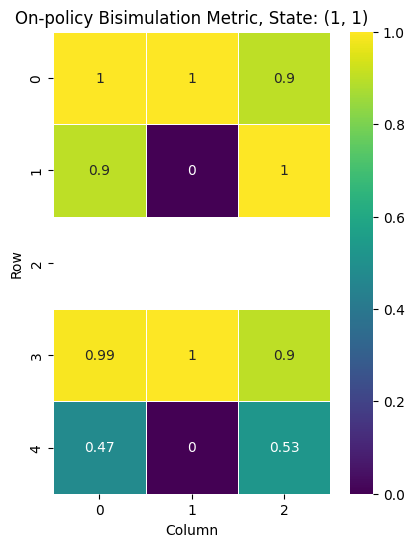

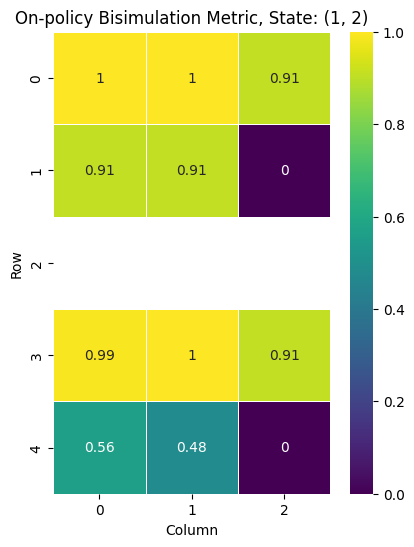

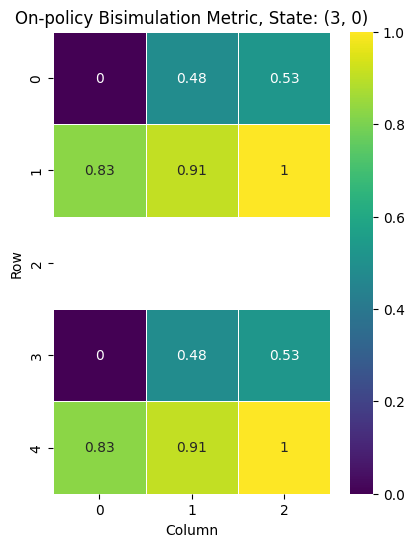

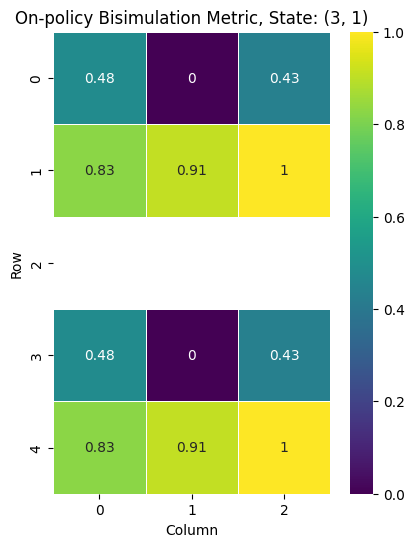

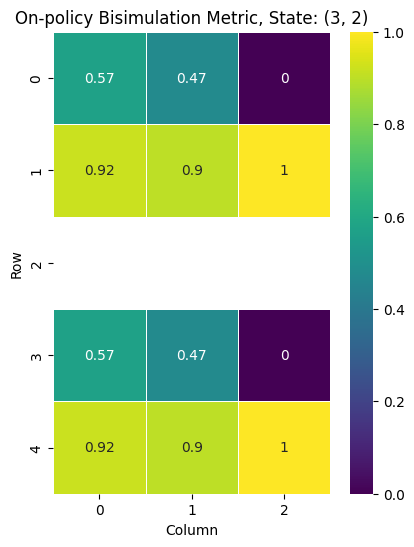

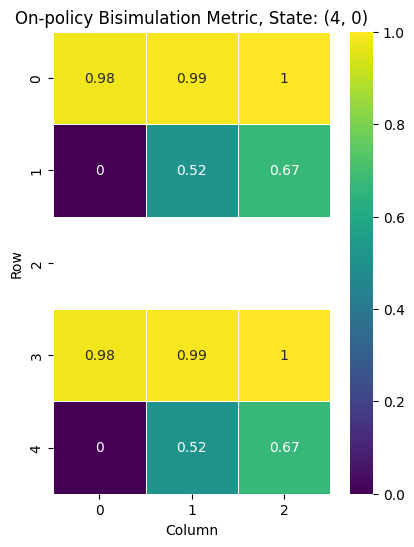

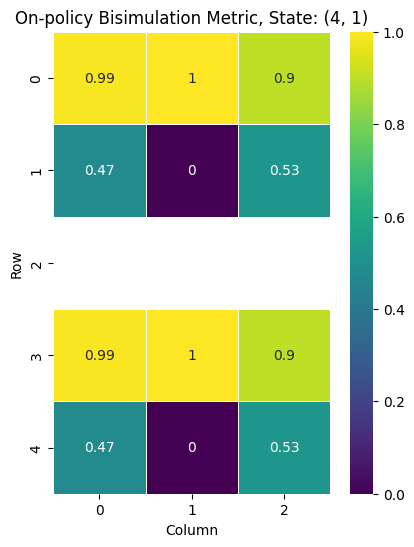

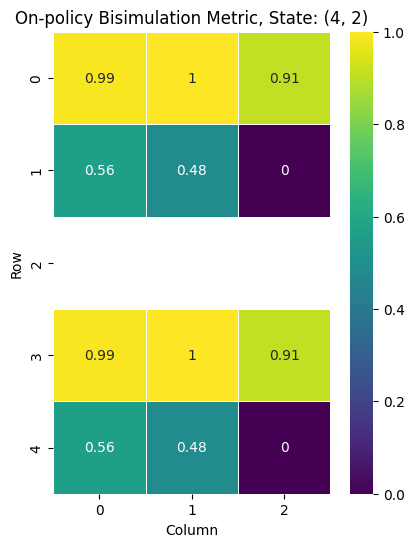

In [72]:
for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i])#, save=True, save_suffix="_grid_world")

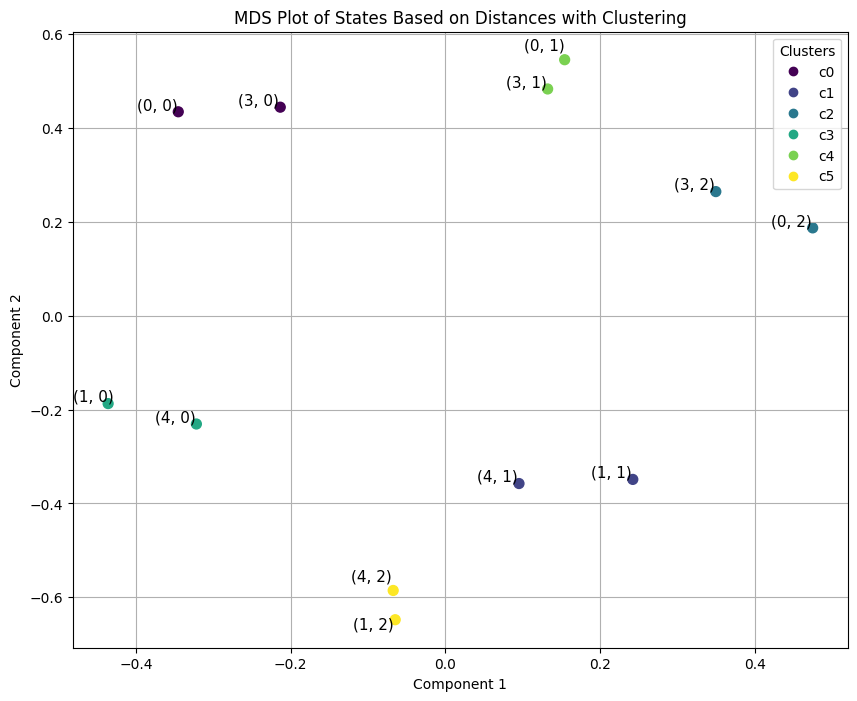

In [73]:
plot_distances(d, states, n_clusters=6)

## Testing grid_world 1

In [74]:
file_path = 'custom_envs/grid_world1.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)
states

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' '.' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]


[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 1),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2)]

In [80]:
rewards

defaultdict(dict,
            {(0, 0): {'up': -1, 'down': 0, 'left': -1, 'right': 0},
             (0, 1): {'up': -1, 'down': 0, 'left': 0, 'right': 1},
             (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 0): {'up': 0, 'down': -1, 'left': -1, 'right': 0},
             (1, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 2): {'up': 1, 'down': -1, 'left': 0, 'right': -1},
             (2, 1): {'up': 0, 'down': 0, 'left': -1, 'right': -1},
             (3, 0): {'up': -1, 'down': 0, 'left': -1, 'right': 0},
             (3, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 1},
             (3, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (4, 0): {'up': 0, 'down': -1, 'left': -1, 'right': 0},
             (4, 1): {'up': 0, 'down': -1, 'left': 0, 'right': 0},
             (4, 2): {'up': 1, 'down': -1, 'left': 0, 'right': -1}})

In [75]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards)
d.shape

(13, 13)

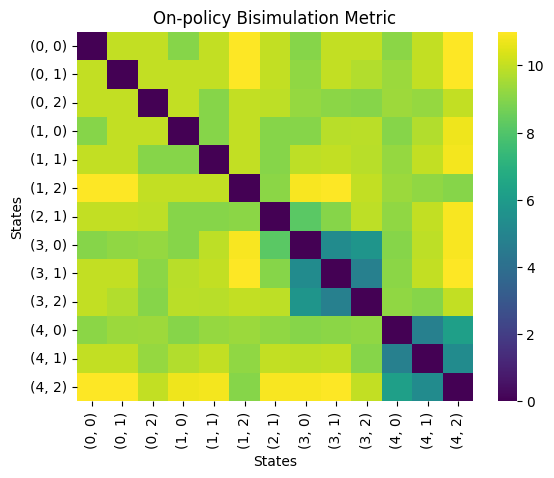

In [76]:
plot_distance_matrix(d, states)

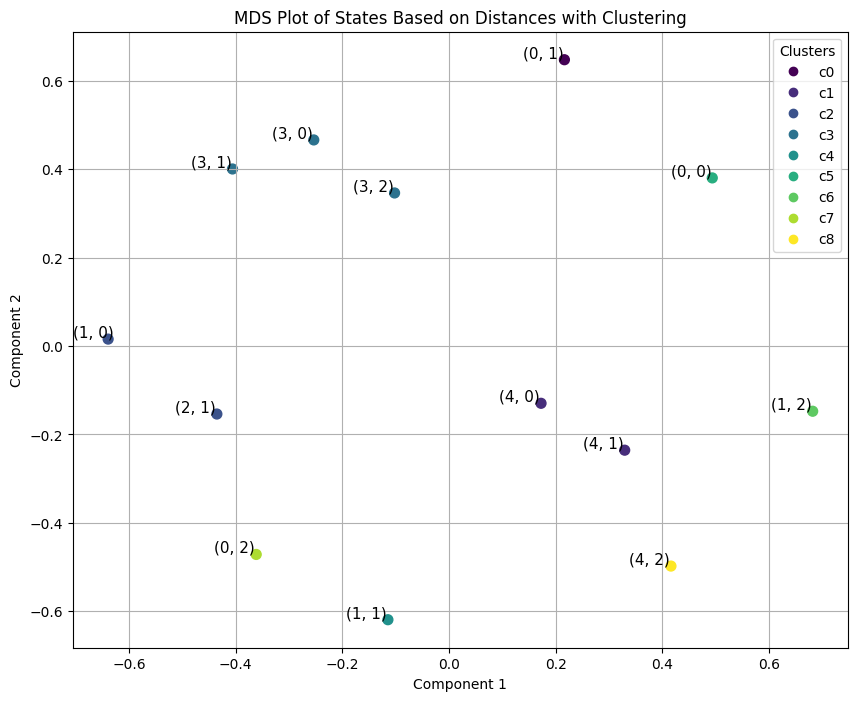

In [84]:
plot_distances(d, states, n_clusters=9)

## On-Policy Bisimulation metric


In [32]:
file_path = 'custom_envs/grid_world.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)
states

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' 'x' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]


[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2)]

In [33]:
rewards

defaultdict(dict,
            {(0, 0): {'up': -1, 'down': 0, 'left': -1, 'right': 0},
             (0, 1): {'up': -1, 'down': 0, 'left': 0, 'right': 1},
             (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 0): {'up': 0, 'down': -1, 'left': -1, 'right': 0},
             (1, 1): {'up': 0, 'down': -1, 'left': 0, 'right': 0},
             (1, 2): {'up': 1, 'down': -1, 'left': 0, 'right': -1},
             (3, 0): {'up': -1, 'down': 0, 'left': -1, 'right': 0},
             (3, 1): {'up': -1, 'down': 0, 'left': 0, 'right': 1},
             (3, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (4, 0): {'up': 0, 'down': -1, 'left': -1, 'right': 0},
             (4, 1): {'up': 0, 'down': -1, 'left': 0, 'right': 0},
             (4, 2): {'up': 1, 'down': -1, 'left': 0, 'right': -1}})

In [34]:
rewards

defaultdict(dict,
            {(0, 0): {'up': -1, 'down': 0, 'left': -1, 'right': 0},
             (0, 1): {'up': -1, 'down': 0, 'left': 0, 'right': 1},
             (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 0): {'up': 0, 'down': -1, 'left': -1, 'right': 0},
             (1, 1): {'up': 0, 'down': -1, 'left': 0, 'right': 0},
             (1, 2): {'up': 1, 'down': -1, 'left': 0, 'right': -1},
             (3, 0): {'up': -1, 'down': 0, 'left': -1, 'right': 0},
             (3, 1): {'up': -1, 'down': 0, 'left': 0, 'right': 1},
             (3, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (4, 0): {'up': 0, 'down': -1, 'left': -1, 'right': 0},
             (4, 1): {'up': 0, 'down': -1, 'left': 0, 'right': 0},
             (4, 2): {'up': 1, 'down': -1, 'left': 0, 'right': -1}})

In [35]:
transitions

defaultdict(dict,
            {(0, 0): {'up': {(0, 0): 1.0},
              'down': {(1, 0): 1.0},
              'left': {(0, 0): 1.0},
              'right': {(0, 1): 1.0}},
             (0, 1): {'up': {(0, 1): 1.0},
              'down': {(1, 1): 1.0},
              'left': {(0, 0): 1.0},
              'right': {(0, 2): 1.0}},
             (0, 2): {'up': {(0, 2): 0.0},
              'down': {(1, 2): 0.0},
              'left': {(0, 1): 0.0},
              'right': {(0, 2): 0.0}},
             (1, 0): {'up': {(0, 0): 1.0},
              'down': {(1, 0): 1.0},
              'left': {(1, 0): 1.0},
              'right': {(1, 1): 1.0}},
             (1, 1): {'up': {(0, 1): 1.0},
              'down': {(1, 1): 1.0},
              'left': {(1, 0): 1.0},
              'right': {(1, 2): 1.0}},
             (1, 2): {'up': {(0, 2): 1.0},
              'down': {(1, 2): 1.0},
              'left': {(1, 1): 1.0},
              'right': {(1, 2): 1.0}},
             (3, 0): {'up': {(3, 0): 1.0},
   

In [36]:
def value_iteration(grid, rewards, gamma=0.9, epsilon=1e-4):
    # Define parameters
    rows, cols = grid.shape
    gamma = 0.9
    epsilon = 1e-4

    # Initialize value function
    V = np.zeros((rows, cols))

    def is_terminal(r, c):
        return grid[r][c] == 'G' or grid[r][c] == 'x'

    # Value iteration
    while True:
        delta = 0
        new_V = np.copy(V)
        for r in range(rows):
            for c in range(cols):
                if not is_terminal(r, c):
                    max_value = float('-inf')
                    for action in ACTION_SPACE:
                        next_r, next_c = get_next_state(r, c, action, grid.shape)
                        if grid[next_r][next_c] != 'x':
                            value = rewards[(r,c)][action] + gamma * V[next_r][next_c]
                            if value > max_value:
                                max_value = value
                    new_V[r][c] = max_value
                    delta = max(delta, abs(new_V[r][c] - V[r][c]))
        V = new_V
        if delta < epsilon:
            break

    # Extract policy
    policy = np.full((rows, cols), ' ')
    for r in range(rows):
        for c in range(cols):
            if not is_terminal(r, c):
                max_value = float('-inf')
                best_action = None
                for action in ACTION_SPACE:
                    next_r, next_c = get_next_state(r, c, action, grid.shape)
                    if grid[next_r][next_c] != 'x':
                        value = rewards[(r,c)][action] + gamma * V[next_r][next_c]
                        if value > max_value:
                            max_value = value
                            best_action = action
                policy[r][c] = best_action[0]  # Just take the first letter of the action
            elif grid[r][c] == 'G':
                policy[r][c] = 'G'
    return V, policy

# Define the grid world environment
file_path = 'custom_envs/grid_world.txt'
grid = read_grid_world(file_path)
print(grid)

# Run value iteration
V, policy = value_iteration(grid, rewards)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' 'x' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]
Optimal Value Function:
[[0.9  1.   0.  ]
 [0.81 0.9  1.  ]
 [0.   0.   0.  ]
 [0.9  1.   0.  ]
 [0.81 0.9  1.  ]]

Optimal Policy:
[['r' 'r' 'G']
 ['u' 'u' 'u']
 [' ' ' ' ' ']
 ['r' 'r' 'G']
 ['u' 'u' 'u']]


In [37]:
def compute_bisimulation_metric(grid, states, rewards, gamma = 0.9, epsilon=1e-5, policy = None):
    """
    Compute the on-policy bisimulation metric for a given MDP and policy.

    Parameters:
    - grid: Grid world environment.
    - states: List of states each state is a tuple (x,y).
    - rewards: Function R(s, a).
    - gamma: Discount factor.
    - epsilon: Convergence threshold.
    - policy: Function π(a | s). It is a matrix of size similar to the grid

    Returns:
    - d: On-policy bisimulation metric.
    """
    n_states = len(states)
    d = np.zeros((n_states, n_states))

    def distance_update(d):
        new_d = np.zeros_like(d)
        for i, s in enumerate(states):
            for j, t in enumerate(states):
                if i != j:

                    # Compute on-policy bisimulation metric
                    if policy:
                        action_s = POLICYACTION2ACTION[policy[s]]
                        action_t = POLICYACTION2ACTION[policy[t]]

                        next_s = get_next_state(s[0], s[1], action_s, grid.shape)
                        next_t = get_next_state(t[0], t[1], action_t, grid.shape)

                        # Get the index of the next states
                        next_s_i = states.index(next_s)
                        next_t_j = states.index(next_t)

                        reward_diff = abs(rewards[s][action_s] - rewards[t][action_t])
                        transition_diff = gamma * d[next_s_i][next_t_j]

                        new_d[i][j] = reward_diff + transition_diff

                    # Compute standard bisimulation metric
                    else:
                        for action in ACTION_SPACE:
                            next_s = get_next_state(s[0], s[1], action, grid.shape)
                            next_t = get_next_state(t[0], t[1], action, grid.shape)

                            # Get the index of the next states
                            next_s_i = states.index(next_s)
                            next_t_j = states.index(next_t)

                            reward_diff = abs(rewards[s][action] - rewards[t][action])
                            transition_diff = gamma * d[next_s_i][next_t_j]

                            act_distance = reward_diff + transition_diff

                            # Get the indext of current states
                            s_i = states.index(s)
                            t_j = states.index(t)

                            if act_distance > new_d[s_i,t_j]:
                                new_d[s_i, t_j] = act_distance
        return new_d

    while True:
        new_d = distance_update(d)
        if np.max(np.abs(new_d - d)) < epsilon:
            break
        d = new_d

    return d

In [38]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards,
                                policy = policy)
d

array([[0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 1.9 , 0.9 , 1.71, 0.  ,
        1.9 ],
       [1.9 , 0.  , 1.  , 1.81, 1.9 , 0.  , 1.9 , 0.  , 1.  , 1.81, 1.9 ,
        0.  ],
       [0.9 , 1.  , 0.  , 0.81, 0.9 , 1.  , 0.9 , 1.  , 0.  , 0.81, 0.9 ,
        1.  ],
       [1.71, 1.81, 0.81, 0.  , 1.71, 1.81, 1.71, 1.81, 0.81, 0.  , 1.71,
        1.81],
       [0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 1.9 , 0.9 , 1.71, 0.  ,
        1.9 ],
       [1.9 , 0.  , 1.  , 1.81, 1.9 , 0.  , 1.9 , 0.  , 1.  , 1.81, 1.9 ,
        0.  ],
       [0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 1.9 , 0.9 , 1.71, 0.  ,
        1.9 ],
       [1.9 , 0.  , 1.  , 1.81, 1.9 , 0.  , 1.9 , 0.  , 1.  , 1.81, 1.9 ,
        0.  ],
       [0.9 , 1.  , 0.  , 0.81, 0.9 , 1.  , 0.9 , 1.  , 0.  , 0.81, 0.9 ,
        1.  ],
       [1.71, 1.81, 0.81, 0.  , 1.71, 1.81, 1.71, 1.81, 0.81, 0.  , 1.71,
        1.81],
       [0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 1.9 , 0.9 , 1.71, 0.  ,
        1.9 ],
       [1.9 , 0.  , 1

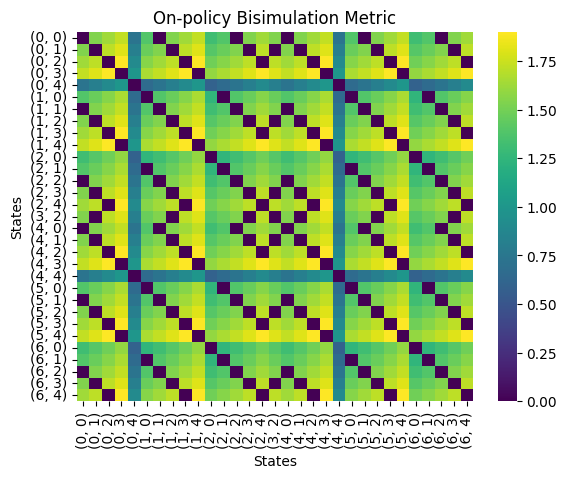

In [58]:
# Plot the heatmap of the distance matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distance_matrix(d, states, annot = False):
    if annot:
        sns.heatmap(d, cmap='viridis', annot=True, fmt=".2f", xticklabels=states, yticklabels=states)
    else:
        sns.heatmap(d, cmap='viridis', xticklabels=states, yticklabels=states)
    plt.xlabel('States')
    plt.ylabel('States')
    plt.title('On-policy Bisimulation Metric')
    plt.show()

plot_distance_matrix(d, states)

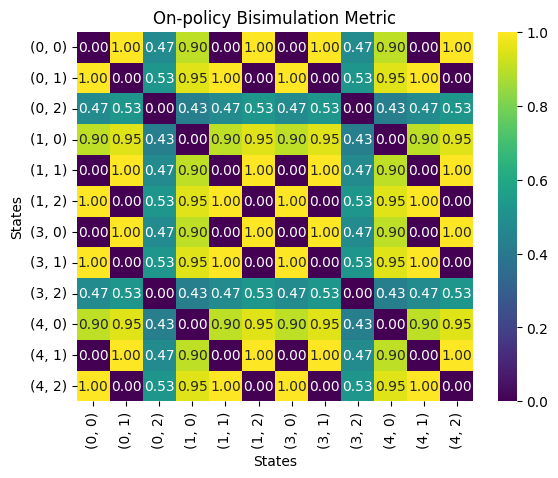

In [40]:
plot_distance_matrix(d / np.max(d), states)


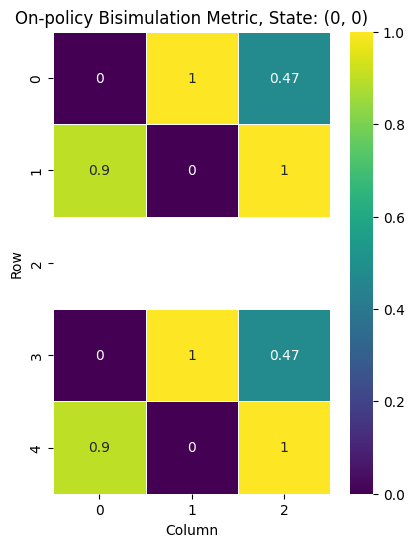

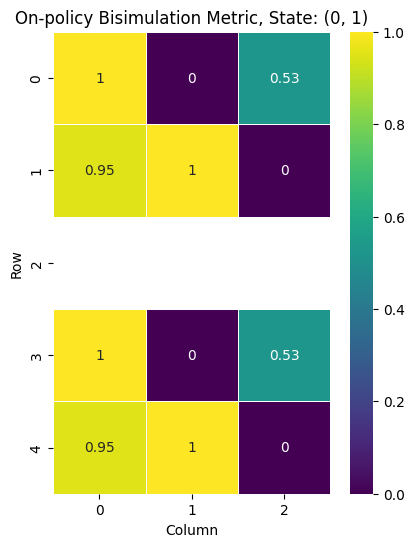

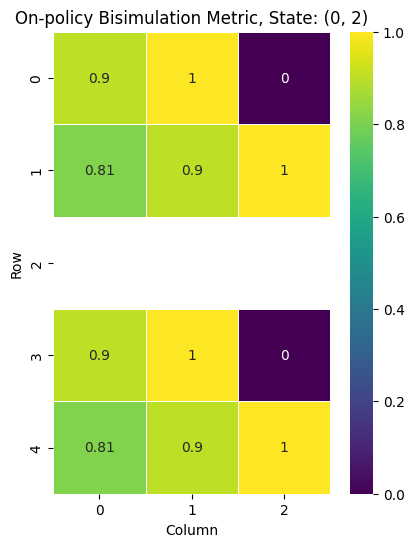

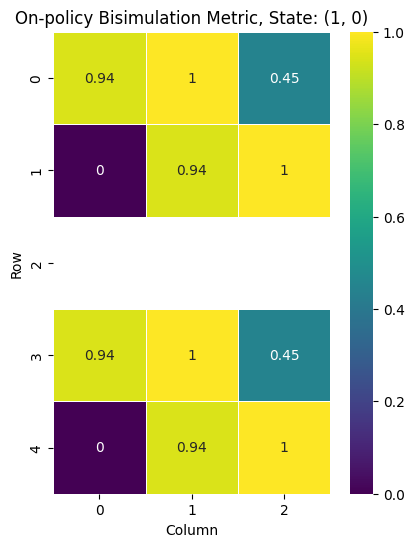

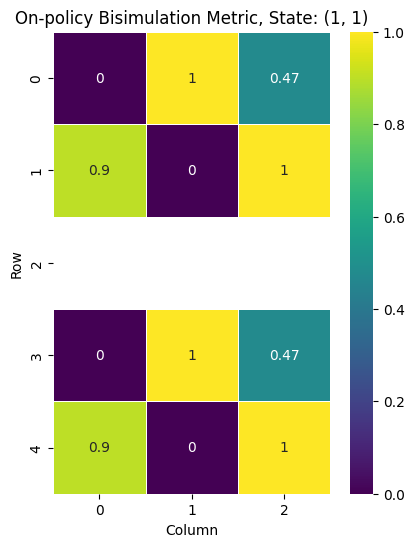

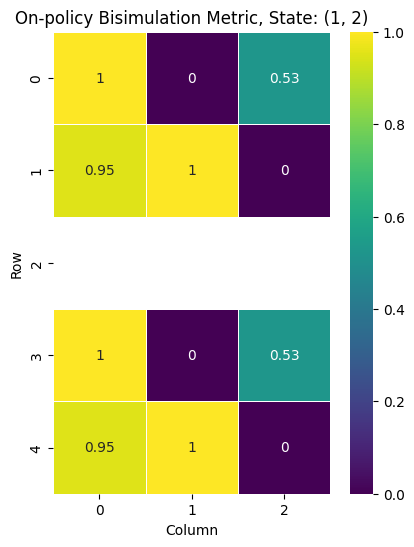

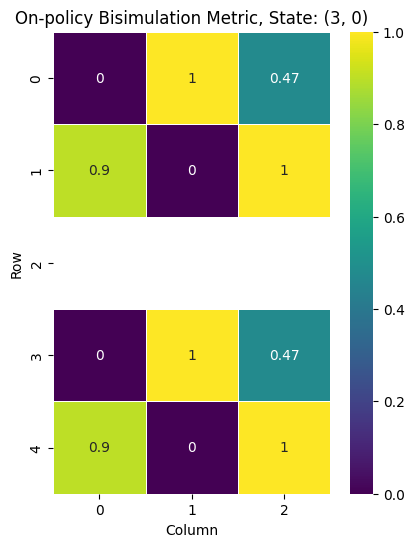

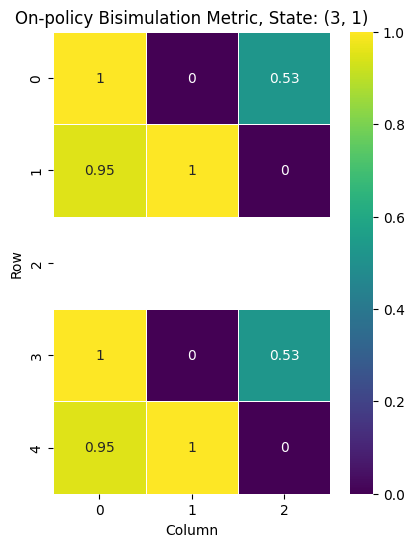

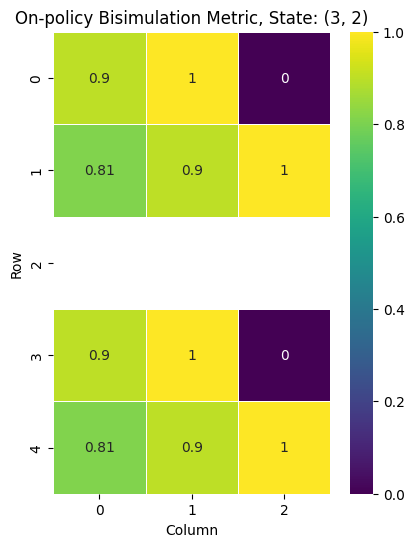

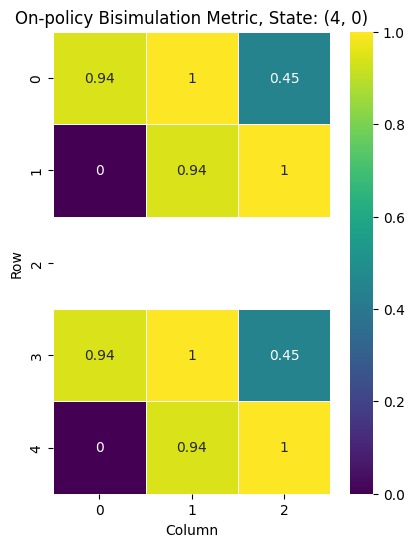

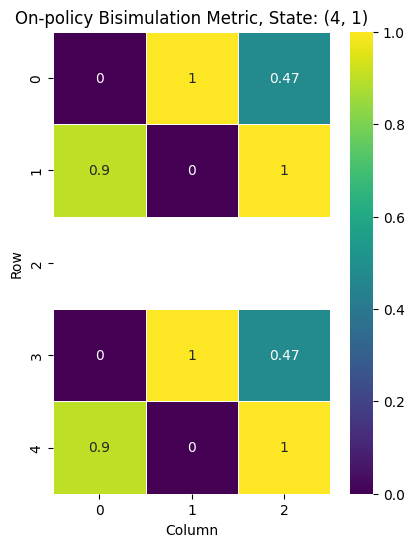

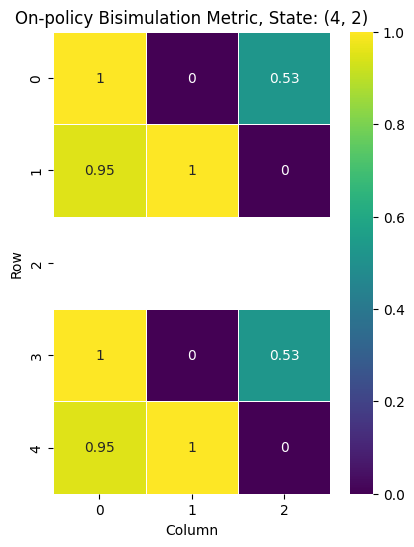

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grid_distance_heatmap(grid, valid_states, distances, state_evaluated = None, save_suffix = "", save = False):
    # Normalize the distance array (max - min normalization) as min is always 0
    max_distance = np.max(distances)
    normalized_distances = distances / max_distance

    # Create a grid with NaN values for invalid states
    heatmap = np.full(grid.shape, np.nan)

    # Fill the grid with the normalized distances
    for idx, (r, c) in enumerate(valid_states):
        heatmap[r, c] = normalized_distances[idx]

    # Plot the heatmap
    plt.figure(figsize=(5, 6))
    sns.heatmap(heatmap, annot=True, cmap='viridis', cbar=True, square=True, linewidths=0.5)
    plt.title(f'On-policy Bisimulation Metric, State: {state_evaluated}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(ticks=np.arange(3) + 0.5, labels=np.arange(3))
    plt.yticks(ticks=np.arange(5) + 0.5, labels=np.arange(5))

    # Save the plot
    if save:
        PATH_TO_SAVE = f'results/on_policy_bisimulation_metric{save_suffix}/'
        plt.savefig(PATH_TO_SAVE + f'on_policy_bisimulation_metric_{state_evaluated}{save_suffix}.png')

    plt.show()


for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i])#, save=True, save_suffix="_grid_world")

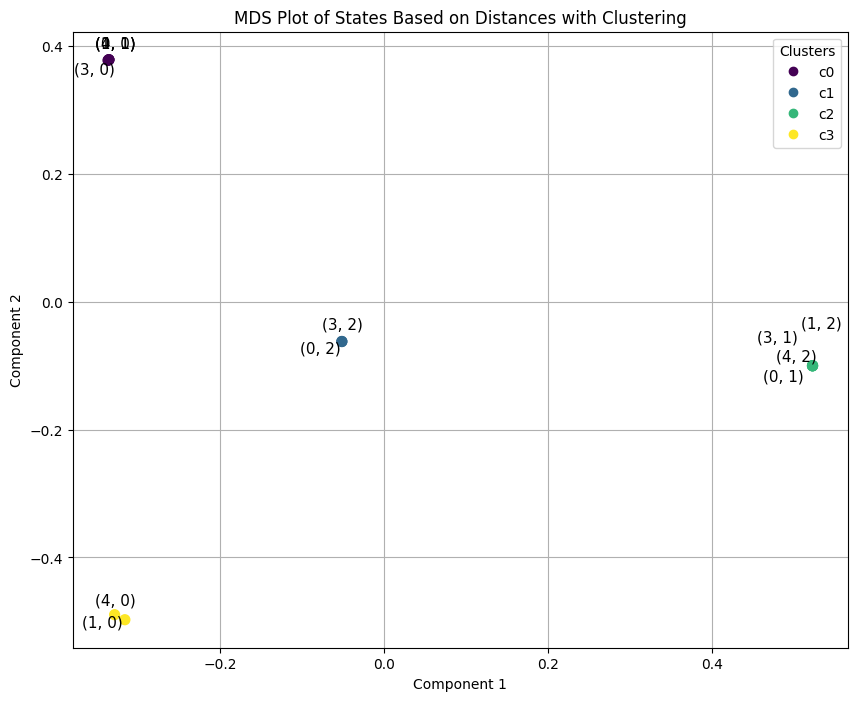

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from adjustText import adjust_text
from sklearn.cluster import KMeans


def plot_distances(d, states, n_clusters = 4):

    # Normalize the distance matrix
    d = d / np.max(d)

    # Apply Multidimensional Scaling (MDS)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    pos = mds.fit_transform(d)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pos)

    # Plot the result
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pos[:, 0], pos[:, 1], c=clusters, cmap='viridis', marker="o", s=50)

    # Annotate points with state numbers and adjust text to avoid overlap
    texts = []
    for i, (x, y) in enumerate(pos):
        texts.append(plt.text(x, y, str(states[i]), fontsize=11, ha='right'))

    adjust_text(texts)#, arrowprops=dict(arrowstyle='->', color='red'))

    # Create a legend
    handles, labels = scatter.legend_elements()
    legend_labels = [f'c{int(i)}' for i in range(len(labels))]
    plt.legend(handles, legend_labels, title="Clusters")

    plt.title('MDS Plot of States Based on Distances with Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

plot_distances(d, states)


## Testing grid_word1.txt with the passage

In [46]:
file_path = 'custom_envs/grid_world1.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)

# Run value iteration
V, policy = value_iteration(grid, rewards)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

[['.' '.' 'G']
 ['.' '.' '.']
 ['x' '.' 'x']
 ['.' '.' 'G']
 ['.' '.' '.']]
Optimal Value Function:
[[0.9  1.   0.  ]
 [0.81 0.9  1.  ]
 [0.   0.9  0.  ]
 [0.9  1.   0.  ]
 [0.81 0.9  1.  ]]

Optimal Policy:
[['r' 'r' 'G']
 ['u' 'u' 'u']
 [' ' 'd' ' ']
 ['r' 'r' 'G']
 ['u' 'u' 'u']]


In [48]:
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards,
                                policy = policy)
d

array([[0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 0.  , 1.9 , 0.9 , 1.71,
        0.  , 1.9 ],
       [1.9 , 0.  , 1.  , 1.81, 1.9 , 0.  , 1.9 , 1.9 , 0.  , 1.  , 1.81,
        1.9 , 0.  ],
       [0.9 , 1.  , 0.  , 0.81, 0.9 , 1.  , 0.9 , 0.9 , 1.  , 0.  , 0.81,
        0.9 , 1.  ],
       [1.71, 1.81, 0.81, 0.  , 1.71, 1.81, 1.71, 1.71, 1.81, 0.81, 0.  ,
        1.71, 1.81],
       [0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 0.  , 1.9 , 0.9 , 1.71,
        0.  , 1.9 ],
       [1.9 , 0.  , 1.  , 1.81, 1.9 , 0.  , 1.9 , 1.9 , 0.  , 1.  , 1.81,
        1.9 , 0.  ],
       [0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 0.  , 1.9 , 0.9 , 1.71,
        0.  , 1.9 ],
       [0.  , 1.9 , 0.9 , 1.71, 0.  , 1.9 , 0.  , 0.  , 1.9 , 0.9 , 1.71,
        0.  , 1.9 ],
       [1.9 , 0.  , 1.  , 1.81, 1.9 , 0.  , 1.9 , 1.9 , 0.  , 1.  , 1.81,
        1.9 , 0.  ],
       [0.9 , 1.  , 0.  , 0.81, 0.9 , 1.  , 0.9 , 0.9 , 1.  , 0.  , 0.81,
        0.9 , 1.  ],
       [1.71, 1.81, 0.81, 0.  , 1.71, 1.81, 1.71, 

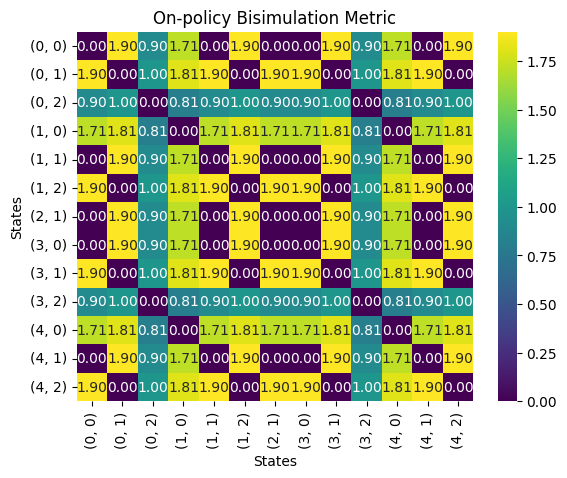

In [52]:
plot_distance_matrix(d, states)

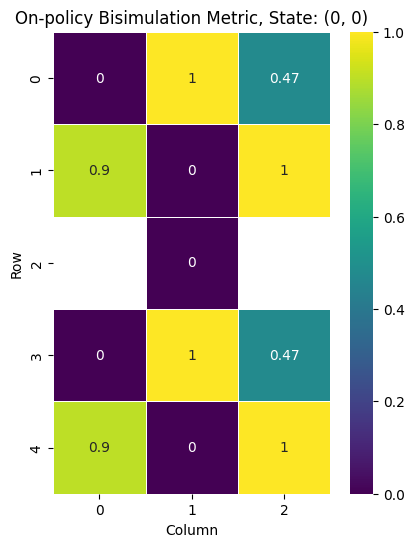

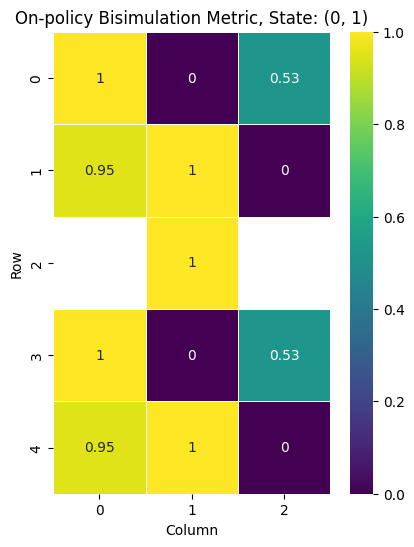

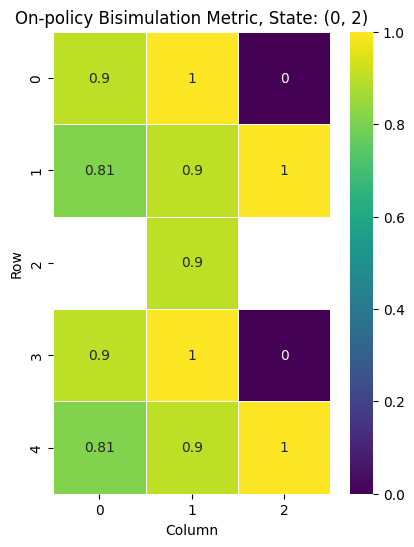

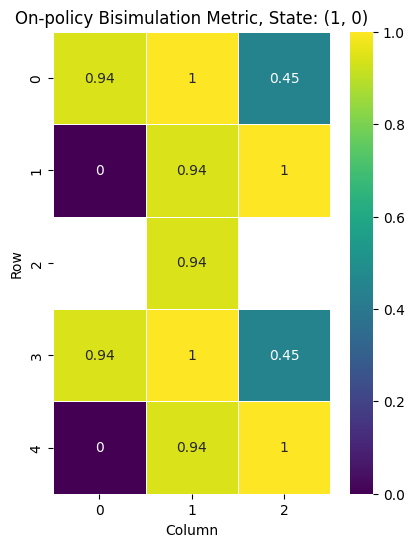

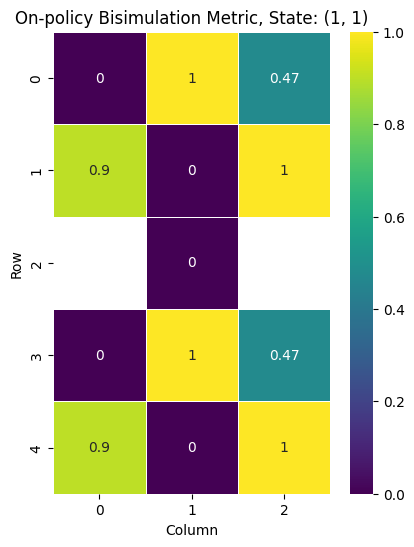

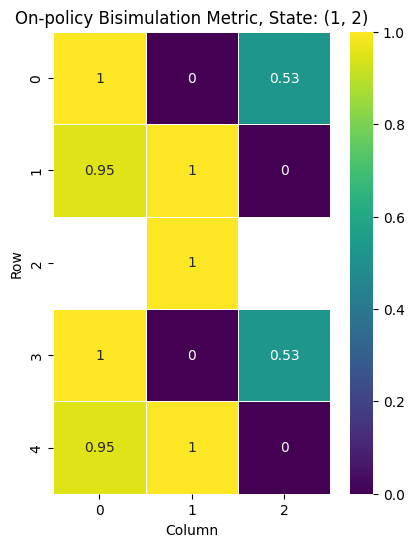

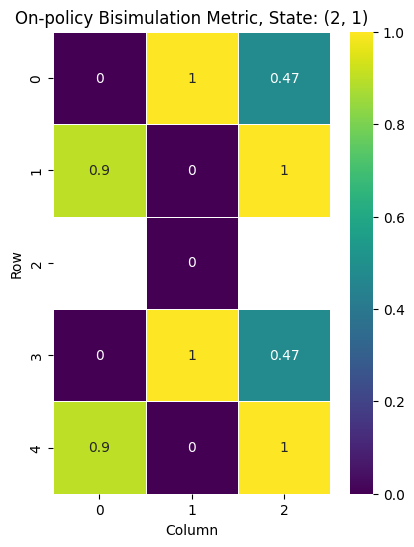

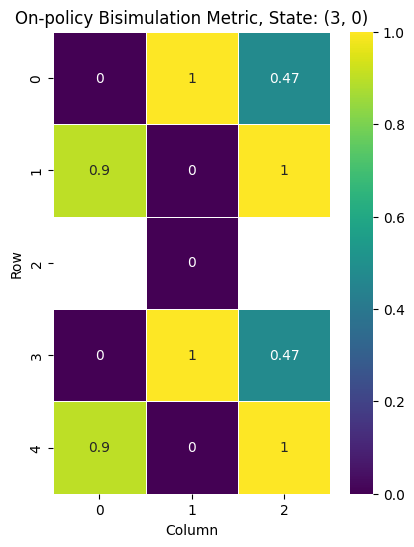

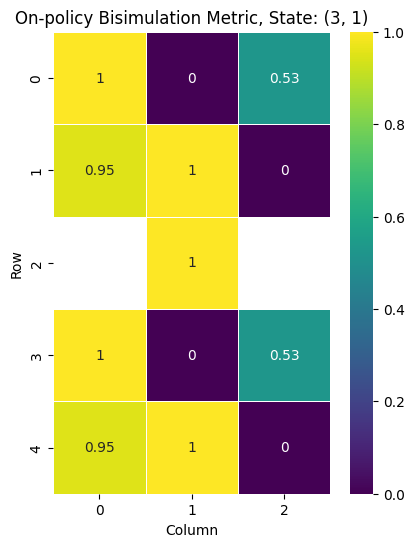

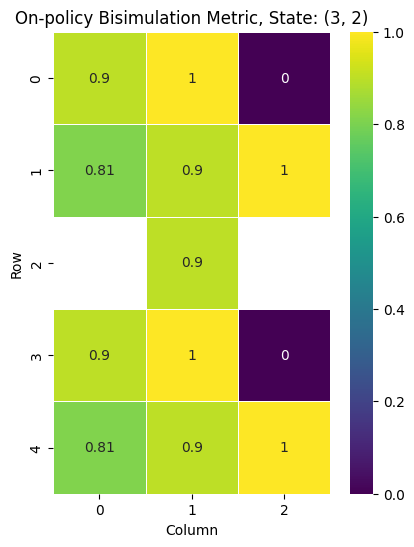

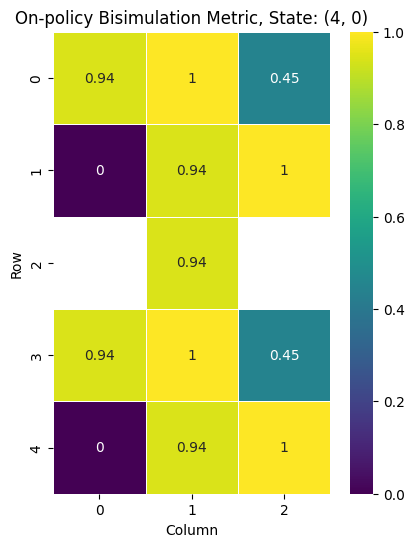

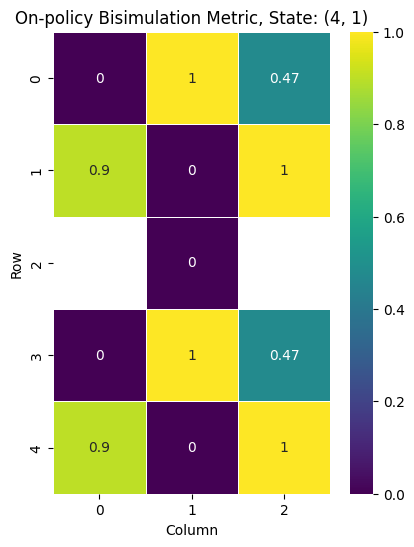

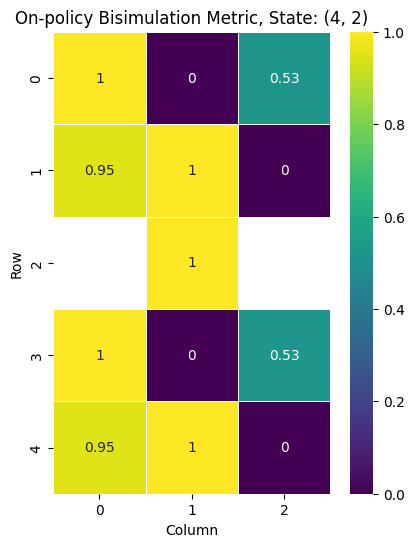

In [50]:
for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i]) #, save=True, save_suffix="_grid_world1")

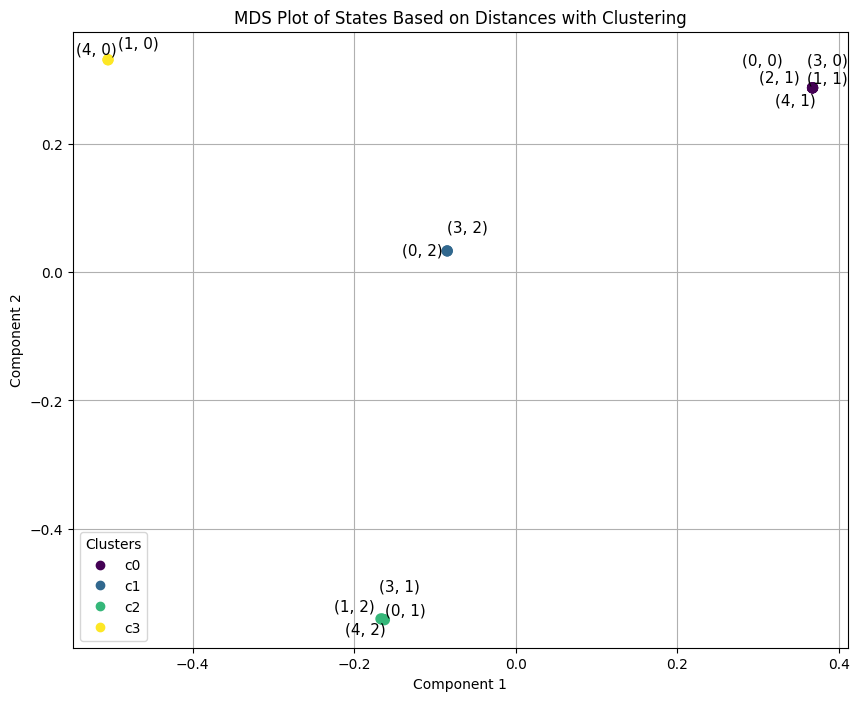

In [53]:
plot_distances(d, states)


# Testing grid_word2.txt

In [54]:
file_path = 'custom_envs/grid_world2.txt'
grid = read_grid_world(file_path)
print(grid)

states, rewards, transitions = calculate_rewards_and_transitions(grid)

# Run value iteration
V, policy = value_iteration(grid, rewards)

# Display the results
print("Optimal Value Function:")
print(V)
print("\nOptimal Policy:")
print(policy)

states = list(rewards.keys())
d = compute_bisimulation_metric(grid = grid,
                                states = states,
                                rewards = rewards,
                                policy = policy)
d

[['.' '.' '.' '.' 'G']
 ['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['x' 'x' '.' 'x' 'x']
 ['.' '.' '.' '.' 'G']
 ['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']]
Optimal Value Function:
[[0.729   0.81    0.9     1.      0.     ]
 [0.6561  0.729   0.81    0.9     1.     ]
 [0.59049 0.6561  0.729   0.81    0.9    ]
 [0.      0.      0.81    0.      0.     ]
 [0.729   0.81    0.9     1.      0.     ]
 [0.6561  0.729   0.81    0.9     1.     ]
 [0.59049 0.6561  0.729   0.81    0.9    ]]

Optimal Policy:
[['r' 'r' 'r' 'r' 'G']
 ['u' 'u' 'u' 'u' 'u']
 ['u' 'u' 'u' 'u' 'u']
 [' ' ' ' 'd' ' ' ' ']
 ['r' 'r' 'r' 'r' 'G']
 ['u' 'u' 'u' 'u' 'u']
 ['u' 'u' 'u' 'u' 'u']]


array([[0.     , 1.539  , 1.629  , 1.729  , 0.729  , 1.3851 , 0.     ,
        1.539  , 1.629  , 1.729  , 1.31949, 1.3851 , 0.     , 1.539  ,
        1.629  , 1.539  , 0.     , 1.539  , 1.629  , 1.729  , 0.729  ,
        1.3851 , 0.     , 1.539  , 1.629  , 1.729  , 1.31949, 1.3851 ,
        0.     , 1.539  , 1.629  ],
       [1.539  , 0.     , 1.71   , 1.81   , 0.81   , 1.4661 , 1.539  ,
        0.     , 1.71   , 1.81   , 1.40049, 1.4661 , 1.539  , 0.     ,
        1.71   , 0.     , 1.539  , 0.     , 1.71   , 1.81   , 0.81   ,
        1.4661 , 1.539  , 0.     , 1.71   , 1.81   , 1.40049, 1.4661 ,
        1.539  , 0.     , 1.71   ],
       [1.629  , 1.71   , 0.     , 1.9    , 0.9    , 1.5561 , 1.629  ,
        1.71   , 0.     , 1.9    , 1.49049, 1.5561 , 1.629  , 1.71   ,
        0.     , 1.71   , 1.629  , 1.71   , 0.     , 1.9    , 0.9    ,
        1.5561 , 1.629  , 1.71   , 0.     , 1.9    , 1.49049, 1.5561 ,
        1.629  , 1.71   , 0.     ],
       [1.729  , 1.81   , 1.9    , 0.   

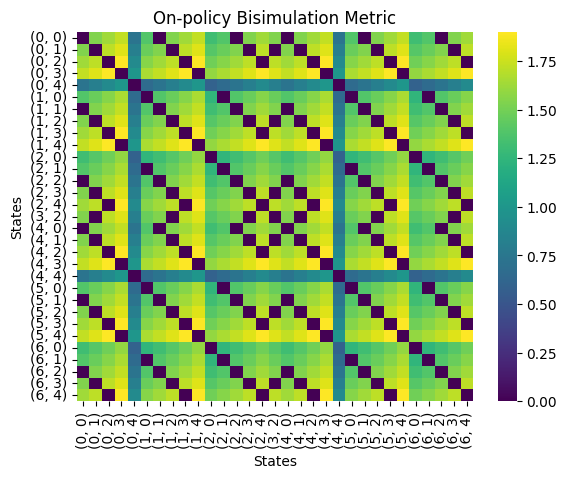

In [59]:
plot_distance_matrix(d, states)

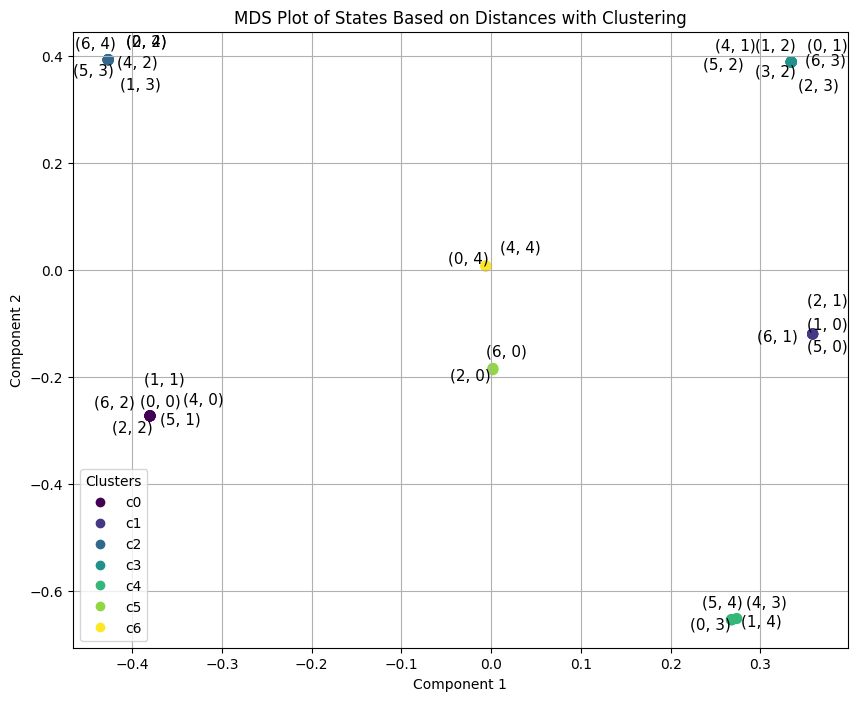

In [60]:
plot_distances(d, states, n_clusters=7)

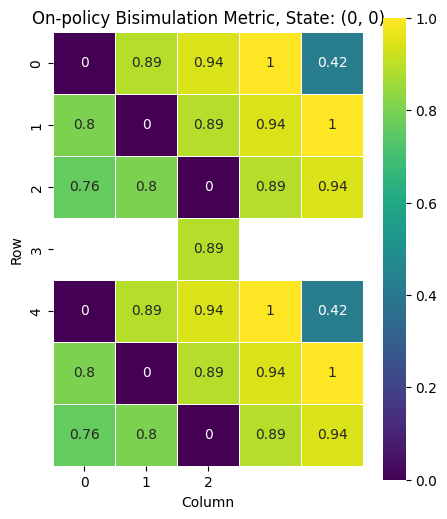

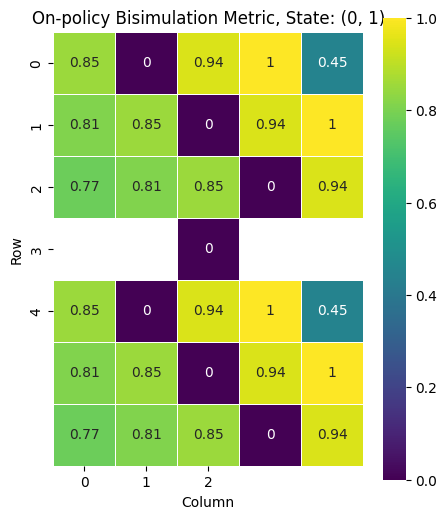

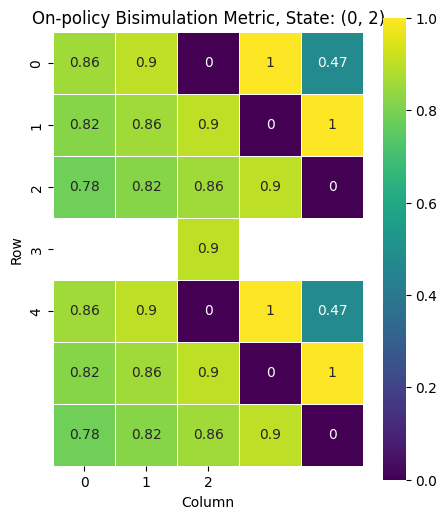

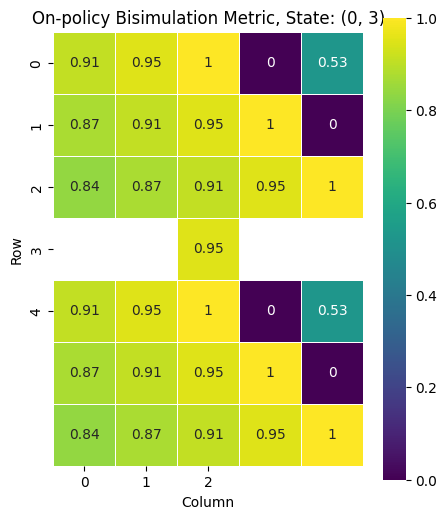

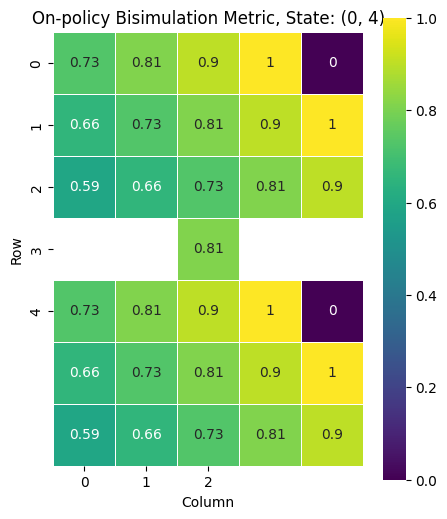

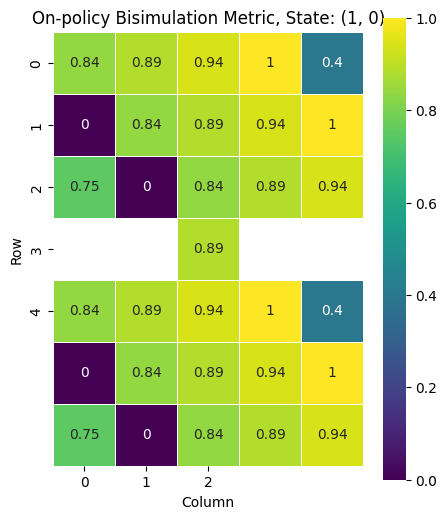

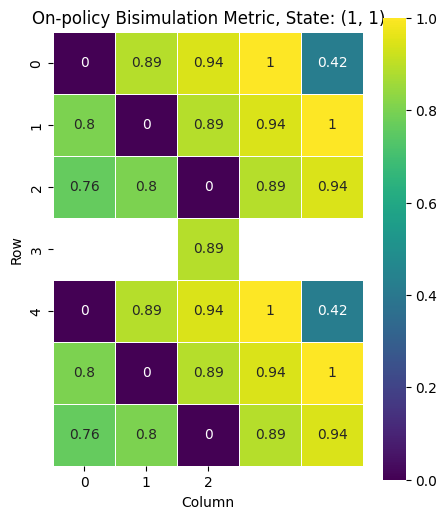

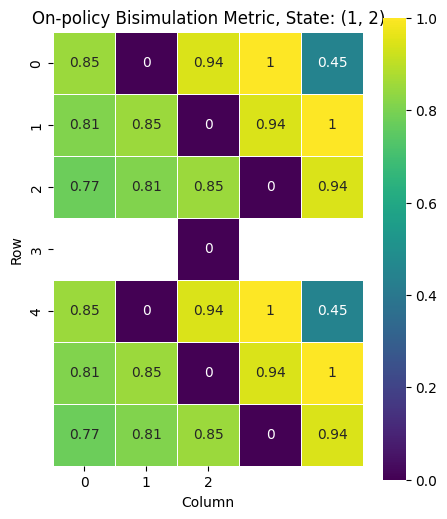

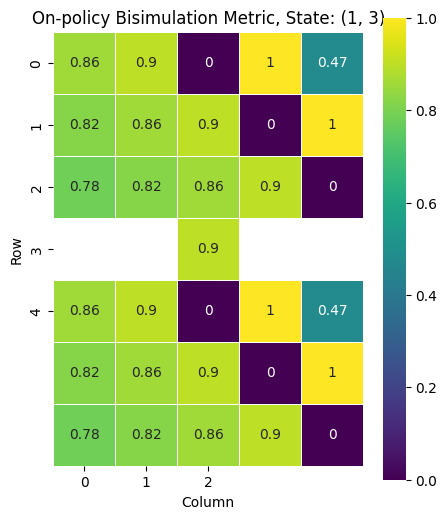

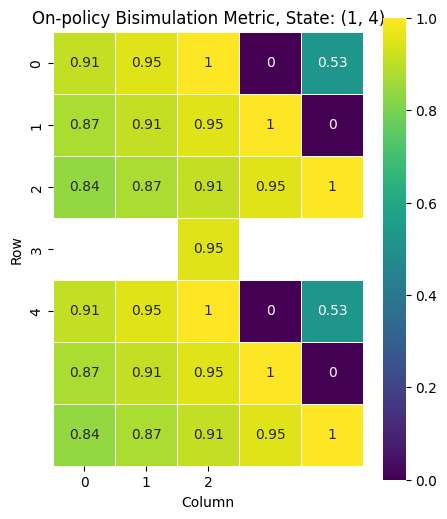

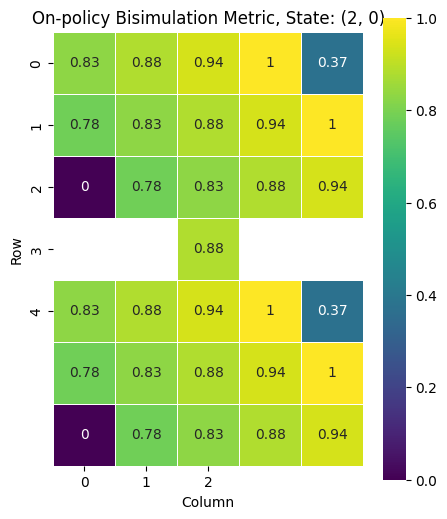

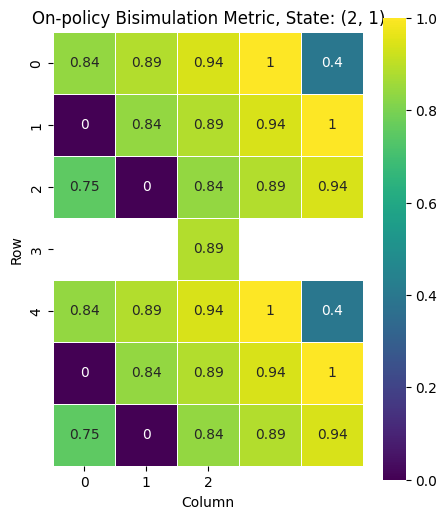

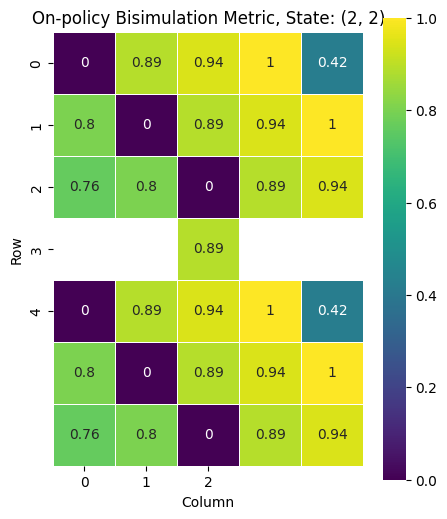

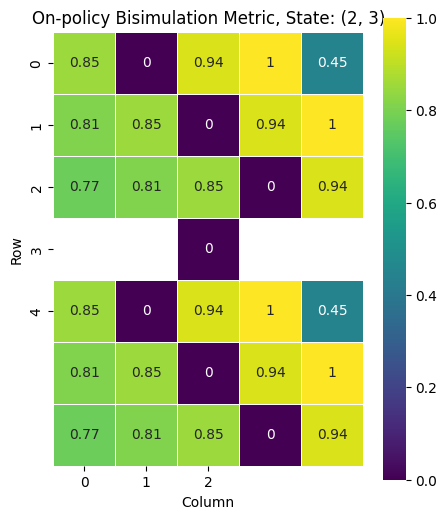

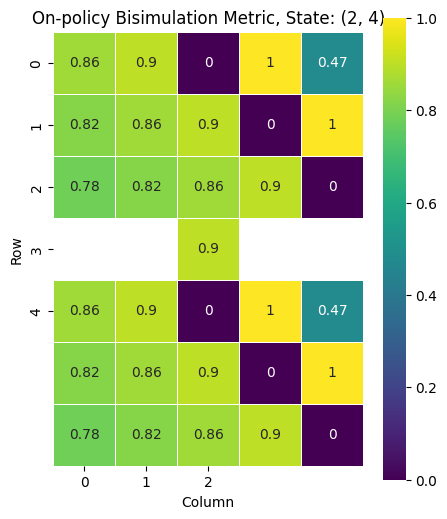

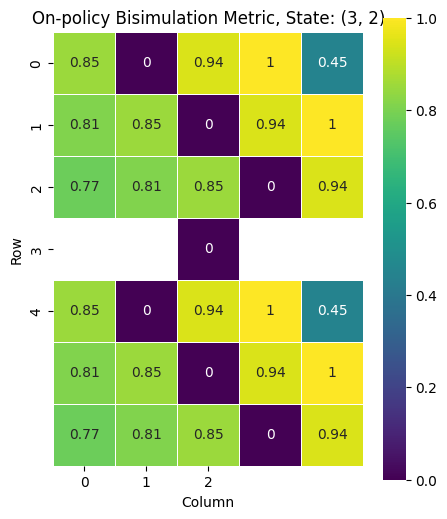

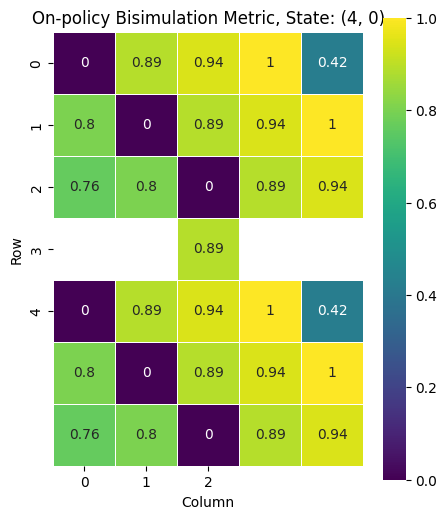

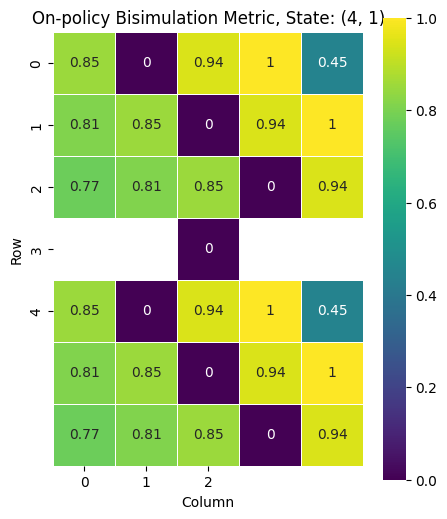

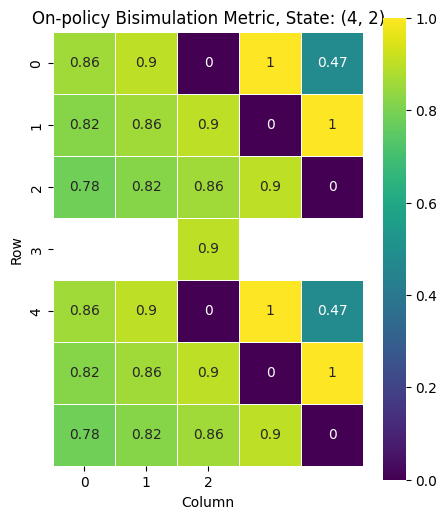

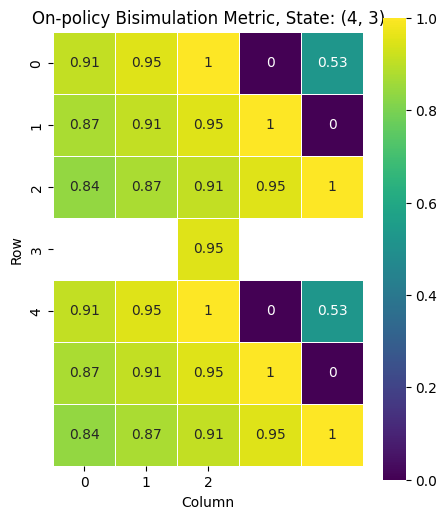

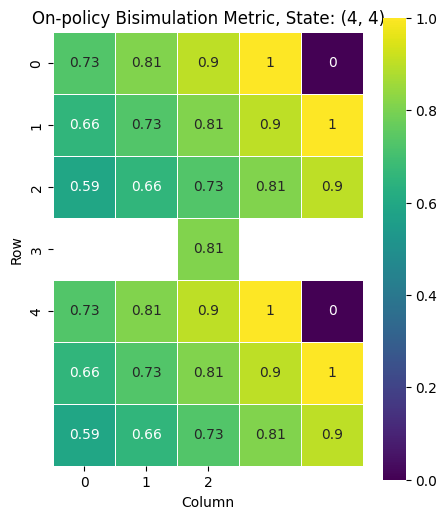

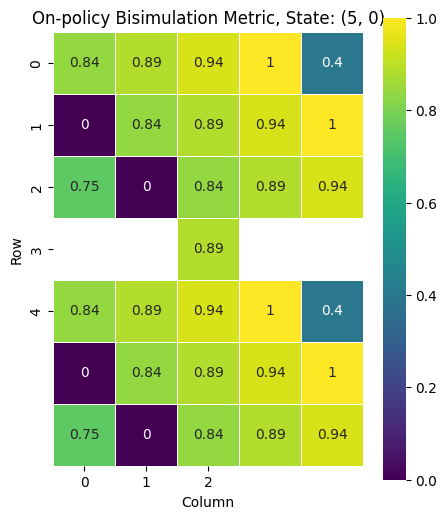

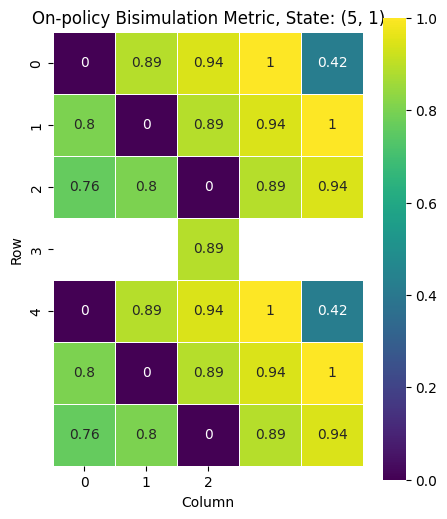

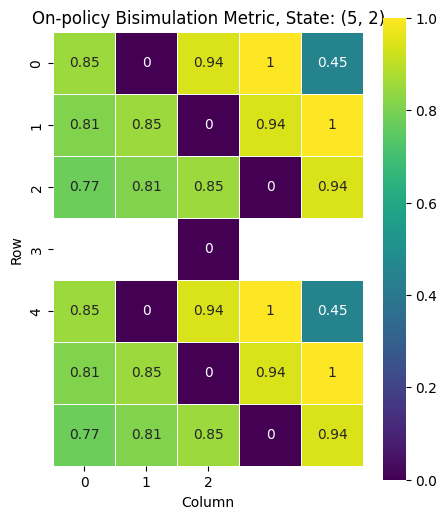

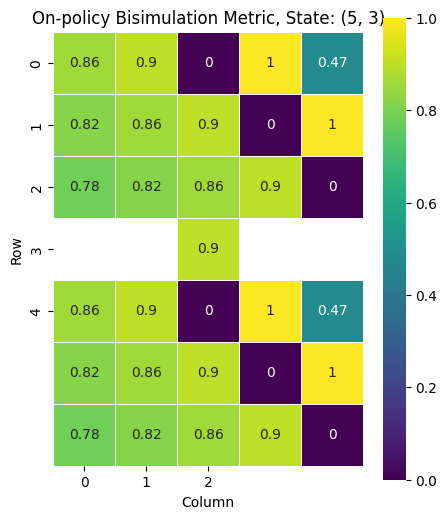

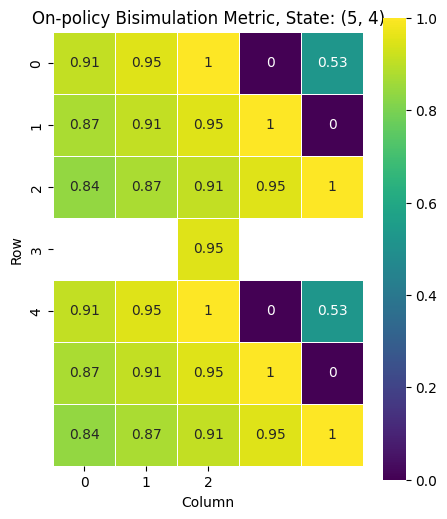

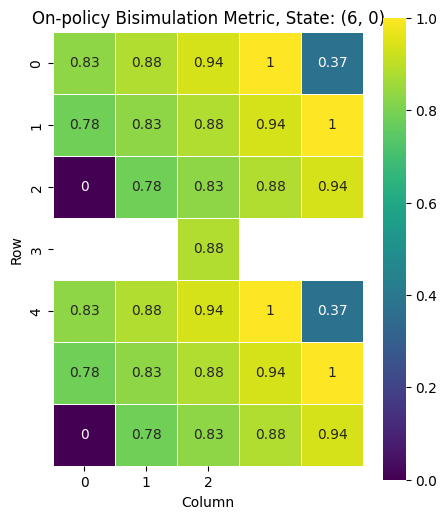

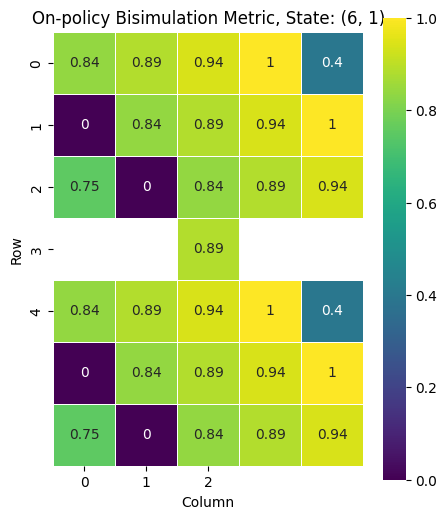

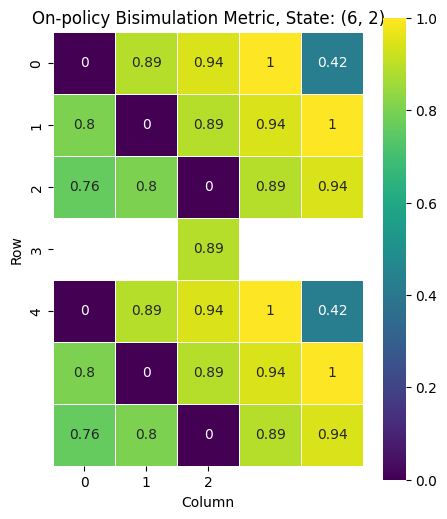

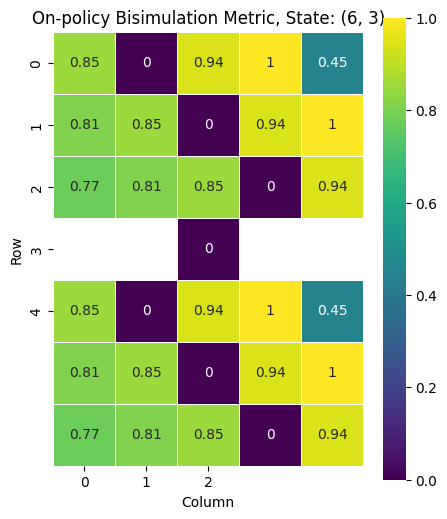

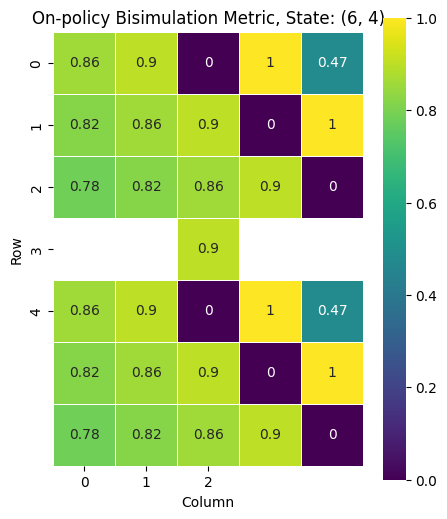

In [61]:
for i, distances in enumerate(d):
    plot_grid_distance_heatmap(grid, states, distances, states[i]) #, save=True, save_suffix="_grid_world2")